</p>
<p>-adding custom schedule [improved learning]</p>
<p>-adjusting hyperparameters, d_model =100, droprate =  0.2</p>
<p>-adding attention weights to output for viz </p>


<style>
td {
  text-align: center;
}

th {
  text-align: center;
}
</style>

# Neural machine classification with a Transformer and Keras

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/text/tutorials/transformer">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/transformer.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/text/blob/master/docs/tutorials/transformer.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/text/docs/tutorials/transformer.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

Creating a classifier model with Transformer based architecture.

Transformers are deep neural networks that replace CNNs and RNNs with [self-attention](https://developers.google.com/machine-learning/glossary#self-attention). Self attention allows Transformers to easily transmit information across the input sequences.

As explained in the [Google AI Blog post](https://ai.googleblog.com/2017/08/transformer-novel-neural-network.html):

> Neural networks for machine classification typically contain an encoder reading the input sentence and generating a representation of it for classification.

## Why Transformers are significant

- Transformers excel at modeling sequential data, such as natural language.
- Unlike the [recurrent neural networks (RNNs)](./text_generation.ipynb), Transformers are parallelizable. This makes them efficient on hardware like GPUs and TPUs. The main reasons is that Transformers replaced recurrence with attention, and computations can happen simultaneously. Layer outputs can be computed in parallel, instead of a series like an RNN.
- Unlike [RNNs](https://www.tensorflow.org/guide/keras/rnn) (like [seq2seq, 2014](https://arxiv.org/abs/1409.3215)) or [convolutional neural networks (CNNs)](https://www.tensorflow.org/tutorials/images/cnn) (for example, [ByteNet](https://arxiv.org/abs/1610.10099)), Transformers are able to capture distant or long-range contexts and dependencies in the data between distant positions in the input or output sequences. Thus, longer connections can be learned. Attention allows each location to have access to the entire input at each layer, while in RNNs and CNNs, the information needs to pass through many processing steps to move a long distance, which makes it harder to learn.
- Transformers make no assumptions about the temporal/spatial relationships across the data. This is ideal for processing a set of objects (for example, [StarCraft units](https://www.deepmind.com/blog/alphastar-mastering-the-real-time-strategy-game-starcraft-ii)).

<img src="https://www.tensorflow.org/images/tutorials/transformer/encoder_self_attention_distribution.png" width="800" alt="Encoder self-attention distribution for the word it from the 5th to the 6th layer of a Transformer trained on English-to-French translation">

Figure 3: The encoder self-attention distribution for the word “it” from the 5th to the 6th layer of a Transformer trained on English-to-French translation (one of eight attention heads). Source: [Google AI Blog](https://ai.googleblog.com/2017/08/transformer-novel-neural-network.html).

## Setup

In [ ]:

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Navigate to the Directory Containing the CSV File
import os
os.chdir('/content/drive/My Drive/DS266 Project')

Begin by installing [TensorFlow Datasets](https://tensorflow.org/datasets) for loading the dataset and [TensorFlow Text](https://www.tensorflow.org/text) for text preprocessing:

In [ ]:
# Install the most re version of TensorFlow to use the improved
# masking support for `tf.keras.layers.MultiHeadAttention`.
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2
!pip uninstall -y -q tensorflow keras tensorflow-estimator tensorflow-text
!pip install protobuf~=3.20.3
!pip install -q tensorflow_datasets
!pip install -q -U tensorflow-text tensorflow

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Package libcudnn8 is not available, but is referred to by another package.
This may mean that the package is missing, has been obsoleted, or
is only available from another source

E: Version '8.1.0.77-1+cuda11.2' for 'libcudnn8' was not found
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 29.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 100.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 101.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 108.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 69.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 286.8/286.8 kB 28.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are i

In [ ]:
# Install compatible TensorFlow version
!pip uninstall tensorflow -y
!pip install tensorflow==2.15

# Reinstall tf-keras to resolve any potential dependency conflicts
!pip uninstall tf-keras -y
!pip install tf-keras

Found existing installation: tensorflow 2.16.1
Uninstalling tensorflow-2.16.1:
  Successfully uninstalled tensorflow-2.16.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 65.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 100.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 40.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 63.1 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.3.2
    Uninstalling ml-dtypes-0.3.2:
      Successfully uninstalled ml-dtypes-0.3.2
  Attempting uninstall: keras
    Found existing installation: keras 3.1.1
    Uninstalling keras-3.1.1:
      Successfully uninstalled keras-3.1.1
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.16.2
    Uninstalling tensorboard-2.16.2:
      Successfully uninstalled tenso

Import the necessary modules:

In [ ]:
!pip install tensorflow==2.15

  Using cached tensorflow-2.15.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (475.2 MB)
  Using cached ml_dtypes-0.2.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.0 MB)
  Using cached tensorboard-2.15.2-py3-none-any.whl (5.5 MB)
  Using cached keras-2.15.0-py3-none-any.whl (1.7 MB)
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.3.2
    Uninstalling ml-dtypes-0.3.2:
      Successfully uninstalled ml-dtypes-0.3.2
  Attempting uninstall: keras
    Found existing installation: keras 3.1.1
    Uninstalling keras-3.1.1:
      Successfully uninstalled keras-3.1.1
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.16.2
    Uninstalling tensorboard-2.16.2:
      Successfully uninstalled tensorboard-2.16.2
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.16.1
    Uninstalling tensorflow-2.16.1:
      Successfully uninstalled tensorflow-2.16.1
ERROR: pip's dependency re

In [ ]:
!pip uninstall tensorflow-text -y
!pip install tensorflow-text==2.15

Found existing installation: tensorflow-text 2.16.1
Uninstalling tensorflow-text-2.16.1:
  Successfully uninstalled tensorflow-text-2.16.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 32.6 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 43.1 MB/s eta 0:00:00
  Attempting uninstall: tf-keras
    Found existing installation: tf_keras 2.16.0
    Uninstalling tf_keras-2.16.0:
      Successfully uninstalled tf_keras-2.16.0


In [ ]:
import logging
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow as tf

import tensorflow_text as text
from tensorflow import keras

## Data handling



### Download the dataset

read the data

In [ ]:
# Read the CSV File
import pandas as pd
tweets_df = pd.read_csv('train.csv')
tweets_df.head(3)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1


### Set up the tokenizer

Now that you have loaded the dataset, you need to tokenize the text, so that each element is represented as a [token](https://developers.google.com/machine-learning/glossary#token) or token ID (a numeric representation).

Tokenization is the process of breaking up text, into "tokens". Depending on the tokenizer, these tokens can represent sentence-pieces, words, subwords, or characters. To learn more about tokenization, visit [this guide](https://www.tensorflow.org/text/guide/tokenizers).

In [ ]:
sentences = tweets_df['text']
labels = tweets_df['target']

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Instantiate the tokenizer
tokenizer = Tokenizer()

# Fit the tokenizer on your text data
tokenizer.fit_on_texts(sentences)


In [ ]:
# List all the methods available for the tokenizer fitted on sentences
[item for item in dir(tokenizer) if not item.startswith('_')]


['analyzer',
 'char_level',
 'document_count',
 'filters',
 'fit_on_sequences',
 'fit_on_texts',
 'get_config',
 'index_docs',
 'index_word',
 'lower',
 'num_words',
 'oov_token',
 'sequences_to_matrix',
 'sequences_to_texts',
 'sequences_to_texts_generator',
 'split',
 'texts_to_matrix',
 'texts_to_sequences',
 'texts_to_sequences_generator',
 'to_json',
 'word_counts',
 'word_docs',
 'word_index']

In [ ]:
MAX_TOKENS =30
# Convert sentences to sequences
sequences = tokenizer.texts_to_sequences(sentences)

# Pad sequences
sequences = pad_sequences(sequences, maxlen=MAX_TOKENS, padding='post')

# Convert labels to NumPy array
labels = labels.to_numpy()

for i in range(4):
  print(sequences[i].shape)
  print(sequences[i])
  print(sequences[i].dtype)
  print(type(sequences[i]))

print(sequences.shape)
print(type(sequences))

(30,)
[ 119 4633   24    4  868    8   21  263  138 1619 4634   89   40    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]
int32
<class 'numpy.ndarray'>
(30,)
[ 189   45  229  799 6954 6955 1404    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]
int32
<class 'numpy.ndarray'>
(30,)
[  40 1751 1620    7 6956    6 6957   24  136 6958   20 1752   39  441
  256   57 2158    6  714 1405   24 1106    0    0    0    0    0    0
    0    0]
int32
<class 'numpy.ndarray'>
(30,)
[ 835 2921   59 4635 1500  256 1405    6   96    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]
int32
<class 'numpy.ndarray'>
(7613, 30)
<class 'numpy.ndarray'>


In [ ]:
print ("original text: ")
for i in range(3):

  print(tweets_df.text.iloc[i])
print ("tokenized text: ")
for i in range(3):
  print(sequences[i])

The distribution of tokens per example in the dataset is as follows:

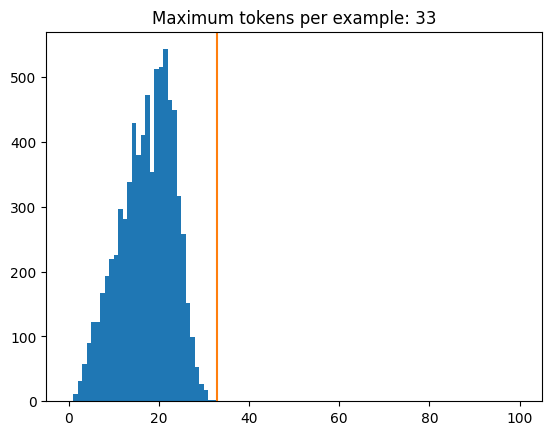

In [ ]:


# Tokenize the sentences
tokenized_sentences = tokenizer.texts_to_sequences(tweets_df['text'])

# Calculate the lengths of the tokenized sentences
lengths = [len(sentence) for sentence in tokenized_sentences]

# Plot the histogram of lengths
plt.hist(lengths, np.linspace(0, 100, 101))
plt.ylim(plt.ylim())
max_length = max(lengths)
plt.plot([max_length, max_length], plt.ylim())
plt.title(f'Maximum tokens per example: {max_length}');


In [ ]:
#convert sequence back to text
def sequence_to_text(sequence):
    # Convert a sequence of indices to text using the tokenizer's index_word dictionary
    return ' '.join([tokenizer.index_word.get(index, '') for index in sequence])



Convert back to English words

In [ ]:
# Convert the sequence to text
text = sequence_to_text(sequences[0])
print(text)
print(labels[0])

### Set up a data pipeline with `tf.data`

The following function takes batches of text as input, and converts them to a format suitable for training.

1. It tokenizes them into ragged batches.
2. It trims each to be no longer than `MAX_TOKENS`.
3. It splits the target (English) tokens into inputs and labels. These are shifted by one step so that at each input location the `label` is the id of the next token.
4. It converts the `RaggedTensor`s to padded dense `Tensor`s.
5. It returns an `(inputs, labels)` pair.


In [ ]:
from sklearn.model_selection import train_test_split
# Shuffle and batch the dataset
BUFFER_SIZE = len(sequences)
BATCH_SIZE = 64  # You can adjust the batch size as needed

# Split the data
sequences_train, sequences_val, labels_train, labels_val = train_test_split(sequences, labels, test_size=0.3)

# Convert to TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((sequences_train, labels_train))
val_dataset = tf.data.Dataset.from_tensor_slices((sequences_val, labels_val))

# Shuffle and batch the datasets
train_dataset = train_dataset.shuffle(len(sequences_train)).batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)




## Test the Dataset

In [ ]:
# For train_batches
for x, y in train_dataset.take(1):  # We only take one batch
    print("Shape of X:", x.shape)
    print("Data type of X:", x.dtype)  # This will print the data type
    print("Content of X:", x.numpy())  # .numpy() converts the tensor to a numpy array
    print("Shape of Y:", y.shape)
    print("Content of Y:", y.numpy())

# For val_batches
for x, y in val_dataset.take(1):  # We only take one batch
    print("Shape of X:", x.shape)
    print("Data type of X:", x.dtype)  # This will print the data type
    print("Content of X:", x.numpy())  # .numpy() converts the tensor to a numpy array
    print("Shape of Y:", y.shape)
    print("Content of Y:", y.numpy())

Shape of X: (64, 30)
Data type of X: <dtype: 'int32'>
Content of X: [[  272     5    52 ...   787     0     0]
 [ 2124    19     5 ...     0     0     0]
 [   21   473   379 ...     0     0     0]
 ...
 [18522  6639    42 ...     0     0     0]
 [ 3787     5  3788 ...     0     0     0]
 [ 1762   542    14 ...     0     0     0]]
Shape of Y: (64,)
Content of Y: [0 0 1 0 0 1 1 0 0 0 1 1 1 1 1 0 1 0 1 0 0 1 0 1 1 0 1 0 0 0 0 0 0 1 0 1 1
 1 0 0 0 1 1 0 1 0 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0]
Shape of X: (64, 30)
Data type of X: <dtype: 'int32'>
Content of X: [[  114   861  1372 ...     0     0     0]
 [20498     9    10 ...     0     0     0]
 [  807   118     6 ...     0     0     0]
 ...
 [16025   274    10 ...     0     0     0]
 [19445   499    70 ...     0     0     0]
 [ 2800   179   827 ...     0     0     0]]
Shape of Y: (64,)
Content of Y: [1 0 1 0 0 0 1 1 0 0 0 0 0 0 0 1 0 1 0 1 1 0 0 0 1 1 0 0 0 0 0 0 1 0 0 1 0
 0 0 0 0 0 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 0 1 0 1]


In [ ]:
for tweet, labels in train_dataset.take(1):
  break

print(tweet.shape)
print(labels.shape)


(64, 30)
(64,)


 </section>

## Define the components

There's a lot going on inside a Transformer. The important things to remember are:

1. It follows the same general pattern as a standard sequence-to-sequence model with an encoder with decoder removed


### The embedding and positional encoding layer

The inputs to both the encoder and decoder use the same embedding and positional encoding logic.

<table>
<tr>
  <th colspan=1>The embedding and positional encoding layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/PositionalEmbedding.png"/>
  </td>
</tr>
</table>

The attention layers used throughout the model see their input as a set of vectors, with no order. Since the model doesn't contain any recurrent or convolutional layers. It needs some way to identify word order, otherwise it would see the input sequence as a [bag of words](https://developers.google.com/machine-learning/glossary#bag-of-words) instance, `how are you`, `how you are`, `you how are`, and so on, are indistinguishable.

A Transformer adds a "Positional Encoding" to the embedding vectors. It uses a set of sines and cosines at different frequencies (across the sequence). By definition nearby elements will have similar position encodings.

The original paper uses the following formula for calculating the positional encoding:

$$\Large{PE_{(pos, 2i)} = \sin(pos / 10000^{2i / d_{model}})} $$
$$\Large{PE_{(pos, 2i+1)} = \cos(pos / 10000^{2i / d_{model}})} $$

Note: The code below implements it, but instead of interleaving the sines and cosines, the vectors of sines and cosines are simply concatenated. Permuting the channels like this is functionally equivalent, and just a little easier to implement and show in the plots below.

In [ ]:
def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)

  pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1)

  return tf.cast(pos_encoding, dtype=tf.float32)

The position encoding function is a stack of sines and cosines that vibrate at different frequencies depending on their location along the depth of the embedding vector. They vibrate across the position axis.

In [ ]:
class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, d_model):
    super().__init__()
    self.d_model = d_model
    self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True)
    self.pos_encoding = positional_encoding(length=2048, depth=d_model)
    #the line below is new
    #self.pos_encoding = tf.cast(self.pos_encoding, tf.float64)

  def compute_mask(self, *args, **kwargs):
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    #x, _ = x #ignore attn weights
    length = tf.shape(x)[1]
    x = self.embedding(x)
    # This factor sets the relative scale of the embedding and positonal_encoding.
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    #x *= tf.math.sqrt(tf.cast(self.d_model, tf.float64))
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    #print("positionalembedding: shape and type:")
    #the casting is new
    #x = tf.cast(x, tf.float64)
    #print(x.dtype)
    #print(tf.shape(x)[1])
    return x

In [ ]:
embed_tweet = PositionalEmbedding(vocab_size=len(tokenizer.word_index) + 1, d_model=512)
embed_tweet.dtype




'float32'

In [ ]:

tweet_emb = embed_tweet(tweet)

tweet_emb.shape

TensorShape([64, 30, 512])

In [ ]:
tweet_emb._keras_mask

<tf.Tensor: shape=(64, 30), dtype=bool, numpy=
array([[ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]])>

### Add and normalize

<table>
<tr>
  <th colspan=2>Add and normalize</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/Add+Norm.png"/>
  </td>
</tr>
</table>

These "Add & Norm" blocks are scattered throughout the model. Each one joins a residual connection and runs the result through a `LayerNormalization` layer.

The easiest way to organize the code is around these residual blocks. The following sections will define custom layer classes for each.

The residual "Add & Norm" blocks are included so that training is efficient. The residual connection provides a direct path for the gradient (and ensures that vectors are **updated** by the attention layers instead of **replaced**), while the normalization maintains a reasonable scale for the outputs.

Note: The implementations, below, use the `Add` layer to ensure that Keras masks are propagated (the `+` operator does not).



### The base attention layer

Attention layers are used throughout the model. These are all identical except for how the attention is configured. Each one contains a `layers.MultiHeadAttention`, a `layers.LayerNormalization` and a `layers.Add`.

<table>
<tr>
  <th colspan=2>The base attention layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/BaseAttention.png"/>
  </td>
</tr>
</table>

To implement these attention layers, start with a simple base class that just contains the component layers. Each use-case will be implemented as a subclass. It's a little more code to write this way, but it keeps the intention clear.

In [ ]:
class BaseAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

### The global self attention layer

This layer is responsible for processing the context sequence, and propagating information along its length:

<table>
<tr>
  <th colspan=1>The global self attention layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/SelfAttention.png"/>
  </td>
</tr>
</table>

Since the context sequence is fixed while the translation is being generated, information is allowed to flow in both directions.

Before Transformers and self attention, models commonly used RNNs or CNNs to do this task:

<table>
<tr>
  <th colspan=1>Bidirectional RNNs and CNNs</th>
</tr>
<tr>
  <td>
   <img width=500 src="https://www.tensorflow.org/images/tutorials/transformer/RNN-bidirectional.png"/>
  </td>
</tr>
<tr>
  <td>
   <img width=500 src="https://www.tensorflow.org/images/tutorials/transformer/CNN.png"/>
  </td>
</tr>
</table>

RNNs and CNNs have their limitations.

- The RNN allows information to flow all the way across the sequence, but it passes through many processing steps to get there (limiting gradient flow). These RNN steps have to be run sequentially and so the RNN is less able to take advantage of modern parallel devices.
- In the CNN each location can be processed in parallel, but it only provides a limited receptive field. The receptive field only grows linearly with the number of CNN layers,  You need to stack a number of Convolution layers to transmit information across the sequence ([Wavenet](https://arxiv.org/abs/1609.03499) reduces this problem by using dilated convolutions).

The global self attention layer on the other hand lets every sequence element directly access every other sequence element, with only a few operations, and all the outputs can be computed in parallel.

To implement this layer you just need to pass the target sequence, `x`, as both the `query`, and `value` arguments to the `mha` layer:

In [ ]:
class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output, attn_scores = self.mha(
        query=x,
        value=x,
        key=x,
        return_attention_scores=True)
    x = self.add([x, attn_output])
    x = self.layernorm(x)

    # Cache the attention scores for plotting later.
    self.last_attn_scores = attn_scores

    return x

In [ ]:
sample_gsa = GlobalSelfAttention(num_heads=2, key_dim=512)

print(tweet_emb.shape)
#print(sample_gsa(tweet_emb))
print(sample_gsa(tweet_emb).shape)

### The feed forward network

The transformer also includes this point-wise feed-forward network in both the encoder and decoder:

<table>
<tr>
  <th colspan=1>The feed forward network</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/FeedForward.png"/>
  </td>
</tr>
</table>

The network consists of two linear layers (`tf.keras.layers.Dense`) with a ReLU activation in-between, and a dropout layer. As with the attention layers the code here also includes the residual connection and normalization:

In [ ]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(d_model),
      tf.keras.layers.Dropout(dropout_rate)
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x)
    return x


Test the layer, the output is the same shape as the input:

In [ ]:
sample_ffn = FeedForward(512, 2048)

print(tweet_emb.shape)
print(sample_ffn(tweet_emb).shape)

### The encoder layer

The encoder contains a stack of `N` encoder layers. Where each `EncoderLayer` contains a `GlobalSelfAttention` and `FeedForward` layer:

<table>
<tr>
  <th colspan=1>The encoder layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/EncoderLayer.png"/>
  </td>
</tr>
</table>

Here is the definition of the `EncoderLayer`:

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()

    self.self_attention = GlobalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x):

    #print(f"Shape of inputs to encoder layer: {x.shape}")  # Add this line
    x = self.self_attention(x)
    #print(f"Shape after self_attention: {x.shape}")  # Add this line

    x = self.ffn(x)
    return x

  @property
  def last_attn_scores(self):
    return self.self_attention.last_attn_scores

And a quick test, the output will have the same shape as the input:

In [ ]:
sample_encoder_layer = EncoderLayer(d_model=512, num_heads=8, dff=2048)

print(tweet_emb.shape)
print(sample_encoder_layer(tweet_emb).shape)
print(sample_encoder_layer(tweet_emb).dtype)

### The encoder

Next build the encoder.

<table>
<tr>
  <th colspan=1>The encoder</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/Encoder.png"/>
  </td>
</tr>
</table>

The encoder consists of:

- A `PositionalEmbedding` layer at the input.
- A stack of `EncoderLayer` layers.

In [ ]:

class Encoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads,
               dff, vocab_size, dropout_rate=0.1):
    super().__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(
        vocab_size=vocab_size, d_model=d_model)

    self.enc_layers = [
        EncoderLayer(d_model=d_model,
                     num_heads=num_heads,
                     dff=dff,
                     dropout_rate=dropout_rate)
        for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x):
    # `x` is token-IDs shape: (batch, seq_len)
    #print(f"Shape of inputs to encoder: {x.shape}")  # Add this line
    x = self.pos_embedding(x)
    #print(f"Shape after pos_embedding: {x.shape}")  # Add this line


    # Add dropout.
    x = self.dropout(x)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x)

    #print("length: ", x.dtype)
    return x  # Shape `(batch_size, seq_len, d_model)`.


  @property
  def last_attn_scores(self):
    return self.enc_layers[-1].last_attn_scores


Test the encoder:

In [ ]:
# Instantiate the encoder.
sample_encoder = Encoder(num_layers=4,
                         d_model=512,
                         num_heads=8,
                         dff=2048,
                         vocab_size=len(tokenizer.word_index) + 1
)

sample_encoder_output = sample_encoder(tweet, training=False)

# Print the shape.
print(tweet.shape)
print(sample_encoder_output[0].shape)  # Shape `(batch_size, input_seq_len, d_model)`.
print(sample_encoder_output[0].dtype)

(64, 30)
(30, 512)
<dtype: 'float32'>


Having created the Transformer encoder, it's time to build the Transformer model and train it.

## The Transformer Classifier

You now have `Encoder`. To complete the `Transformer Classifier` model, you need to add a final linear (`Dense`) layer which converts the resulting vector into output of probability.

The output of the encoder is the input to this final linear layer.

Create the `Transformer` by extending `tf.keras.Model`:

> Note: The [original paper](https://arxiv.org/pdf/1706.03762.pdf), section 3.4, shares the weight matrix between the embedding layer and the final linear layer. To keep things simple, this tutorial uses two separate weight matrices.

##This model is based on last hidden state

In [ ]:
class TransformerClassifier(tf.keras.Model):
  def __init__(self, *, num_layers, d_model, num_heads, dff,
               input_vocab_size, dropout_rate=0.1):
    super().__init__()
    self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=input_vocab_size,
                           dropout_rate=dropout_rate)

    self.final_layer = tf.keras.layers.Dense(1, activation='sigmoid')

  def call(self, inputs):
    # To use a Keras model with `.fit` you must pass all your inputs in the
    # first argument.
    context = inputs
    #print(f"Shape of inputs to transformer: {inputs.shape}")  # Add this line
    #print(f"Shape of inputs to transformer: {inputs.dtype}")  # Add this line
    #print((f"end printing shapes and type of input"))

    context = self.encoder(context)  # (batch_size, context_len, d_model)
    logits = self.final_layer(context[:, -1, :])  # Use the last hidden state
    #print(f"end transformer")  # Add this line
    return logits



### Hyperparameters

To keep this example small and relatively fast, the number of layers (`num_layers`), the dimensionality of the embeddings (`d_model`), and the internal dimensionality of the `FeedForward` layer (`dff`) have been reduced.

The base model described in the original Transformer paper used `num_layers=6`, `d_model=512`, and `dff=2048`.

The number of self-attention heads remains the same (`num_heads=8`).


In [ ]:
num_layers = 2
d_model = 100
dff = 512
num_heads = 4
dropout_rate = 0.3

### Try it out

In [ ]:
def plot_history(history):
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.xticks(range(0, len(history['loss'] + 1)))
  plt.plot(history['loss'], label="training", marker='o')
  plt.plot(history['val_loss'], label="validation", marker='o')
  plt.legend()
  plt.show()

Instantiate the `Transformer` model:

In [ ]:

transformer = TransformerClassifier(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size= len(tokenizer.word_index) + 1,
    dropout_rate=dropout_rate)


In [ ]:
len(tokenizer.word_index) + 1

22701

Test it:

In [ ]:
output = transformer(tweet)

print(tweet.shape)
print(output.shape)

(64, 30)
(64, 1)


In [ ]:
attn_scores = transformer.encoder.last_attn_scores
print(attn_scores.shape)  # (batch, heads, target_seq, input_seq)

(64, 4, 30, 30)


In [ ]:
"""
weights = transformer(tweet)


print(len(weights))
weights[0].shape
"""

64


TensorShape([1])

Print the summary of the model:

In [ ]:
print(transformer.summary())


Model: "transformer_classifier_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_11 (Encoder)        multiple                  2799524   
                                                                 
 dense_68 (Dense)            multiple                  101       
                                                                 
Total params: 2799625 (10.68 MB)
Trainable params: 2799625 (10.68 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


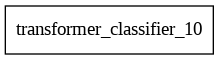

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(transformer, to_file="model_diagram.png", show_shapes=True, show_layer_names=True)

## Training

It's time to prepare the model and start training it.

### Set up the optimizer

Use the Adam optimizer with a custom learning rate scheduler according to the formula in the original Transformer [paper](https://arxiv.org/abs/1706.03762).

$$\Large{lrate = d_{model}^{-0.5} * \min(step{\_}num^{-0.5}, step{\_}num \cdot warmup{\_}steps^{-1.5})}$$

In [ ]:

class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)


### Set up the loss and metrics

In [ ]:

learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)


Test the custom learning rate scheduler:

Text(0.5, 0, 'Train Step')

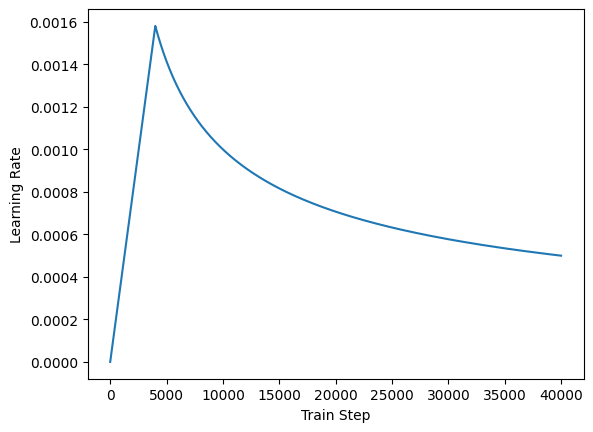

In [ ]:
plt.plot(learning_rate(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

Instantiate the optimizer (in this example it's `tf.keras.optimizers.Adam`):

### Train the model

With all the components ready, configure the training procedure using `model.compile`, and then run it with `model.fit`:

Note: This takes about an hour to train in Colab.

##Save best model

In [ ]:
from keras import losses
checkpoint_dir = './model_checkpoints/'
checkpoint_filepath = checkpoint_dir + 'tx_w_embeddings_cl2a.{epoch:02d}-{val_accuracy:.2f}'

callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        monitor="val_loss", #'val_loss'
        save_best_only=True,
        save_weights_only=True,  # Add this line
    )
]

transformer.compile(
    loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'],
    run_eagerly=True)


Epoch 1/10
84/84 [==============================] - 61s 720ms/step - loss: 0.7651 - accuracy: 0.5254 - val_loss: 0.6840 - val_accuracy: 0.5574
Epoch 2/10
84/84 [==============================] - 61s 730ms/step - loss: 0.7145 - accuracy: 0.5342 - val_loss: 0.6778 - val_accuracy: 0.5652
Epoch 3/10
84/84 [==============================] - 61s 733ms/step - loss: 0.6880 - accuracy: 0.5750 - val_loss: 0.6589 - val_accuracy: 0.5941
Epoch 4/10
84/84 [==============================] - 61s 728ms/step - loss: 0.6441 - accuracy: 0.6260 - val_loss: 0.5999 - val_accuracy: 0.6852
Epoch 5/10
84/84 [==============================] - 61s 733ms/step - loss: 0.5272 - accuracy: 0.7502 - val_loss: 0.6161 - val_accuracy: 0.7307
Epoch 6/10
84/84 [==============================] - 62s 732ms/step - loss: 0.4642 - accuracy: 0.7898 - val_loss: 0.5165 - val_accuracy: 0.7710
Epoch 7/10
84/84 [==============================] - 60s 713ms/step - loss: 0.3831 - accuracy: 0.8347 - val_loss: 0.5177 - val_accuracy: 0.7688

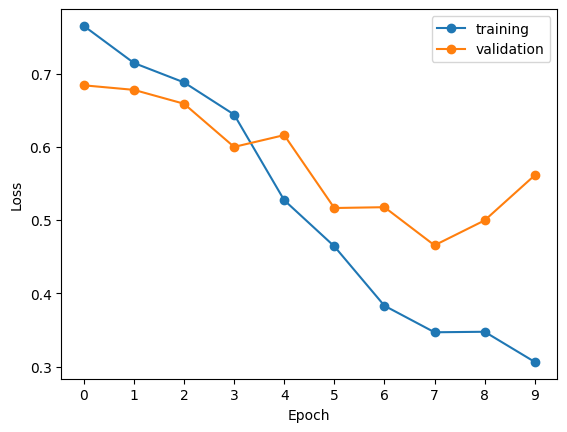

In [ ]:
history = transformer.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=callbacks_list)

# Convert the return value into a DataFrame so we can see the train loss
# and binary accuracy after every epoch.
history = pd.DataFrame(history.history)
plot_history(history)

#Lets have some fun

Need to def the transformerclassifier class and all its dependencies.

Data set up below

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')
# Navigate to the Directory Containing the CSV File
import os
os.chdir('/content/drive/My Drive/DS266 Project')

Mounted at /content/drive


In [ ]:
#

#change file path appropiately
checkpoint_dir = './model_checkpoints/'
checkpoint_filepath = checkpoint_dir + 'tx_w_embeddings_cl2a.06-0.79'


In [ ]:
#use same num_heads, num_layers, d_model, dff that model was built with
#for loading
num_layers = 2
d_model = 100
dff = 512
num_heads = 8
dropout_rate = 0.3
MAX_TOKENS =30

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
sentences2 = tweets_df['text']
labels2 = tweets_df['target']

# Instantiate the tokenizer
tokenizer = Tokenizer()

# Fit the tokenizer on your text data
tokenizer.fit_on_texts(sentences2)

NameError: name 'tweets_df' is not defined

In [ ]:
# Create a new instance of the model
transformer = TransformerClassifier(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size= len(tokenizer.word_index) + 1,
    dropout_rate=dropout_rate)

# Build the model by calling it on some data
#remember to define tweet
transformer(tweet)

# Now load the weights
transformer.load_weights(checkpoint_filepath)


####Supporting Functions

In [ ]:

def classification(prediction):


  t ='''
        TRUE TRUE TRUE TRUE TRUE TRUE
        TRUE TRUE TRUE TRUE TRUE TRUE
        TRUE TRUE TRUE TRUE TRUE TRUE
                  TRUE TRUE
                  TRUE TRUE
                  TRUE TRUE
                  TRUE TRUE
                  TRUE TRUE
                  TRUE TRUE
                  TRUE TRUE
                  TRUE TRUE'''

  f = '''
         FALSE FALSE FALSE FALSE
         FALSE FALSE FALSE FALSE
         FALSE
         FALSE
         FALSE FALSE FALSE FALSE
         FALSEFALSE FALSE FALSE
         FALSE
         FALSE
         FALSE
         FALSE
         FALSE'''

  class_names = [f, t]
  # Since this is a binary classification,round the prediction to the nearest integer (0 or 1)
  print('probability of true: ', prediction[0])
  rounded_predictions = np.round(prediction[0])

  # Now, you can use this rounded prediction to index into your class_names
  predicted_class = class_names[int(rounded_predictions[0])]

  print(predicted_class)


In [ ]:
@tf.function
def forward_and_get_attn_scores(input):
    # Forward pass on your model
    output = transformer(input)

    # Get attention scores
    attn_scores = transformer.encoder.last_attn_scores
    #prediction = transformer.predict(input)
    return output, attn_scores




In [ ]:
import string
def format_sentence(text, max_sentence_length=30):

    print('original sentence: ', text)

    # Lowercase the text
    text = text.lower()

  # Remove punctuation

    text = text.translate(str.maketrans('', '', string.punctuation))


    print('untokenized sentence: ', text)

    MAX_TOKENS =max_sentence_length
    # Convert sentences to sequences
    sequences2 = tokenizer.texts_to_sequences([text])
    #print("len: ", len(sequences2))
    # Pad sequences
    sequences2 = pad_sequences(sequences2, maxlen=MAX_TOKENS, padding='post')

    print('tokenized sentence: ', sequences2)
    #print('vector of first word: ', vectorized_sentences[0, 0])

    return sequences2


In [ ]:
#use predict to get probability of being TRUE
predictions = transformer.predict(format_sentence("This is a real tragedy"))
classification(predictions)

original sentence:  This is a real tragedy
untokenized sentence:  this is a real tragedy
tokenized sentence:  [[ 21  11   5 368 452   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0]]
1/1 [==============================] - 0s 27ms/step
probability of true:  [0.08952069]

         FALSE FALSE FALSE FALSE
         FALSE FALSE FALSE FALSE
         FALSE
         FALSE
         FALSE FALSE FALSE FALSE
         FALSEFALSE FALSE FALSE
         FALSE
         FALSE
         FALSE
         FALSE
         FALSE


In [ ]:
# use forward_and_get_attn_scores to get attention scores and prediction probability
prediction, attn_scores = forward_and_get_attn_scores(format_sentence("This is a real tragedy"))
classification(prediction)
print(attn_scores.shape)
# print the attention scores
print('atention scores:')
print(attn_scores[0, 0, 0])



original sentence:  This is a real tragedy
untokenized sentence:  this is a real tragedy
tokenized sentence:  [[ 21  11   5 368 452   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0]]
probability of true:  tf.Tensor([0.08952071], shape=(1,), dtype=float32)

         FALSE FALSE FALSE FALSE
         FALSE FALSE FALSE FALSE
         FALSE
         FALSE
         FALSE FALSE FALSE FALSE
         FALSEFALSE FALSE FALSE
         FALSE
         FALSE
         FALSE
         FALSE
         FALSE
(1, 8, 30, 30)
atention scores:
tf.Tensor(
[8.3616050e-04 3.5789985e-02 3.3327464e-03 4.8255995e-03 9.5521545e-01
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00

In [ ]:
predictions = transformer.predict(format_sentence("am eating ice cream"))
classification(predictions)

original sentence:  am eating ice cream
untokenized sentence:  am eating ice cream
tokenized sentence:  [[ 175 3073 1436 2272    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]]
1/1 [==============================] - 0s 31ms/step
[0.02751251]

         FALSE FALSE FALSE FALSE
         FALSE FALSE FALSE FALSE
         FALSE
         FALSE
         FALSE FALSE FALSE FALSE
         FALSEFALSE FALSE FALSE
         FALSE
         FALSE
         FALSE
         FALSE
         FALSE


In [ ]:
predictions = transformer.predict(format_sentence('am eating barbed wire'))
classification(predictions)

original sentence:  am eating barbed wire
untokenized sentence:  am eating barbed wire
tokenized sentence:  [[ 175 3073 3055    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]]
1/1 [==============================] - 0s 64ms/step
[0.02963198]

         FALSE FALSE FALSE FALSE
         FALSE FALSE FALSE FALSE
         FALSE
         FALSE
         FALSE FALSE FALSE FALSE
         FALSEFALSE FALSE FALSE
         FALSE
         FALSE
         FALSE
         FALSE
         FALSE


In [ ]:
predictions = transformer.predict(format_sentence('just got sent this &*() from Ruby Alaska as smoke from wildfires pours into a school: http://www.'))
classification(predictions)

original sentence:  just got sent this &*() from Ruby Alaska as smoke from wildfires pours into a school: http://www.
untokenized sentence:  just got sent this  from ruby alaska as smoke from wildfires pours into a school httpwww
tokenized sentence:  [[  34  100 1221   21   22 6959 2159   30  271   22 1500 6960   69    5
   187    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]]
1/1 [==============================] - 0s 30ms/step
[0.8504302]

        TRUE TRUE TRUE TRUE TRUE TRUE
        TRUE TRUE TRUE TRUE TRUE TRUE
        TRUE TRUE TRUE TRUE TRUE TRUE
                  TRUE TRUE
                  TRUE TRUE
                  TRUE TRUE
                  TRUE TRUE
                  TRUE TRUE
                  TRUE TRUE
                  TRUE TRUE
                  TRUE TRUE


In [ ]:
predictions = transformer.predict(format_sentence('disaster'))
classification(predictions)

original sentence:  disaster
untokenized sentence:  disaster
tokenized sentence:  [[76  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]]
1/1 [==============================] - 0s 28ms/step
[0.99260944]

        TRUE TRUE TRUE TRUE TRUE TRUE
        TRUE TRUE TRUE TRUE TRUE TRUE
        TRUE TRUE TRUE TRUE TRUE TRUE
                  TRUE TRUE
                  TRUE TRUE
                  TRUE TRUE
                  TRUE TRUE
                  TRUE TRUE
                  TRUE TRUE
                  TRUE TRUE
                  TRUE TRUE


In [ ]:
predictions = transformer.predict(format_sentence('A sunami just occured!'))
classification(predictions)

original sentence:  A sunami just occured!
untokenized sentence:  a sunami just occured
tokenized sentence:  [[ 5 34  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]]
1/1 [==============================] - 0s 38ms/step
[0.0248036]

         FALSE FALSE FALSE FALSE
         FALSE FALSE FALSE FALSE
         FALSE
         FALSE
         FALSE FALSE FALSE FALSE
         FALSEFALSE FALSE FALSE
         FALSE
         FALSE
         FALSE
         FALSE
         FALSE


In [ ]:
predictions = transformer.predict(format_sentence('A fire just occured!'))
classification(predictions)

original sentence:  A fire just occured!
untokenized sentence:  a fire just occured
tokenized sentence:  [[ 5 45 34  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]]
1/1 [==============================] - 0s 197ms/step
[0.2026446]

         FALSE FALSE FALSE FALSE
         FALSE FALSE FALSE FALSE
         FALSE
         FALSE
         FALSE FALSE FALSE FALSE
         FALSEFALSE FALSE FALSE
         FALSE
         FALSE
         FALSE
         FALSE
         FALSE


###Salient Maps

#Ignore from this point down

You can now test the model by performing a translation. The following steps are used for inference:

* Encode the input sentence using the Portuguese tokenizer (`tokenizers.pt`). This is the encoder input.
* The decoder input is initialized to the `[START]` token.
* Calculate the padding masks and the look ahead masks.
* The `decoder` then outputs the predictions by looking at the `encoder output` and its own output (self-attention).
* Concatenate the predicted token to the decoder input and pass it to the decoder.
* In this approach, the decoder predicts the next token based on the previous tokens it predicted.

Note: The model is optimized for _efficient training_ and makes a next-token prediction for each token in the output simultaneously. This is redundant during inference, and only the last prediction is used.  This model can be made more efficient for inference if you only calculate the last prediction when running in inference mode (`training=False`).

Define the `Translator` class by subclassing `tf.Module`:

## Export the model

You have tested the model and the inference is working. Next, you can export it as a `tf.saved_model`. To learn about saving and loading a model in the SavedModel format, use [this guide](https://www.tensorflow.org/guide/saved_model).

Create a class called `ExportTranslator` by subclassing the `tf.Module` subclass with a `tf.function` on the `__call__` method:

In [ ]:
class ExportTranslator(tf.Module):
  def __init__(self, translator):
    self.translator = translator

  @tf.function(input_signature=[tf.TensorSpec(shape=[], dtype=tf.string)])
  def __call__(self, sentence):
    (result,
     tokens,
     attention_weights) = self.translator(sentence, max_length=MAX_TOKENS)

    return result

In the above `tf.function` only the output sentence is returned. Thanks to the [non-strict execution](https://tensorflow.org/guide/intro_to_graphs) in `tf.function` any unnecessary values are never computed.

Wrap `translator` in the newly created `ExportTranslator`:

In [ ]:
translator = ExportTranslator(translator)

Since the model is decoding the predictions using `tf.argmax` the predictions are deterministic. The original model and one reloaded from its `SavedModel` should give identical predictions:

In [ ]:
translator('este é o primeiro livro que eu fiz.').numpy()

b"and i ' s a lot of the world ."

In [ ]:
tf.saved_model.save(translator, export_dir='translator')

In [ ]:
reloaded = tf.saved_model.load('translator')

In [ ]:
reloaded('este é o primeiro livro que eu fiz.').numpy()

b"and i ' s a lot of the world ."

## Conclusion

In this tutorial you learned about:

* The Transformers and their significance in machine learning
* Attention, self-attention and multi-head attention
* Positional encoding with embeddings
* The encoder-decoder architecture of the original Transformer
* Masking in self-attention
* How to put it all together to translate text

The downsides of this architecture are:

- For a time-series, the output for a time-step is calculated from the *entire history* instead of only the inputs and current hidden-state. This _may_ be less efficient.
- If the input has a temporal/spatial relationship, like text or images, some positional encoding must be added or the model will effectively see a bag of words.

If you want to practice, there are many things you could try with it. For example:

* Use a different dataset to train the Transformer.
* Create the "Base Transformer" or "Transformer XL" configurations from the original paper by changing the hyperparameters.
* Use the layers defined here to create an implementation of [BERT](https://arxiv.org/abs/1810.04805)
* Use Beam search to get better predictions.

There are a wide variety of Transformer-based models, many of which improve upon the 2017 version of the original Transformer with encoder-decoder, encoder-only and decoder-only architectures.

Some of these models are covered in the following research publications:

* ["Efficient Transformers: a survey"](https://arxiv.org/abs/2009.06732) (Tay et al., 2022)
* ["Formal algorithms for Transformers"](https://arxiv.org/abs/2207.09238) (Phuong and Hutter, 2022).
* [T5 ("Exploring the limits of transfer learning with a unified text-to-text Transformer")](https://arxiv.org/abs/1910.10683) (Raffel et al., 2019)

You can learn more about other models in the following Google blog posts:

* [PaLM](https://ai.googleblog.com/2022/04/pathways-language-model-palm-scaling-to.html).
* [LaMDA](https://ai.googleblog.com/2022/01/lamda-towards-safe-grounded-and-high.html)
* [MUM](https://blog.google/products/search/introducing-mum/)
* [Reformer](https://ai.googleblog.com/2020/01/reformer-efficient-transformer.html)
* [BERT](https://ai.googleblog.com/2018/11/open-sourcing-bert-state-of-art-pre.html)

If you're interested in studying how attention-based models have been applied in tasks outside of natural language processing, check out the following resources:

- Vision Transformer (ViT): [Transformers for image recognition at scale](https://ai.googleblog.com/2020/12/transformers-for-image-recognition-at.html)
- [Multi-task multitrack music transcription (MT3)](https://magenta.tensorflow.org/transcription-with-transformers) with a Transformer
- [Code generation with AlphaCode](https://www.deepmind.com/blog/competitive-programming-with-alphacode)
- [Reinforcement learning with multi-game decision Transformers](https://ai.googleblog.com/2022/07/training-generalist-agents-with-multi.html)
- [Protein structure prediction with AlphaFold](https://www.nature.com/articles/s41586-021-03819-2)
- [OptFormer: Towards universal hyperparameter optimization with Transformers](http://ai.googleblog.com/2022/08/optformer-towards-universal.html)
